In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.utils.extmath import randomized_svd

from xgboost import XGBRegressor

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Layer, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [5]:
from scipy.stats import loguniform, randint, uniform
from scipy.linalg import pinv

In [6]:
import time

In [7]:
import warnings
warnings.simplefilter("ignore")

# 1. Подготовка данных и предварительный анализ

In [8]:
df = pd.read_csv("data/data.csv")
df

match_date       team_1       team_2  t1_points  t2_points  \
0     2016-12-18       CLOUD9  HELLRAISERS         13         16   
1     2016-12-18    IMMORTALS           G2         17         19   
2     2016-12-18  MOUSESPORTS    IMMORTALS         16          3   
3     2016-12-18     DIGNITAS           G2         16          9   
4     2016-12-18        OPTIC  HELLRAISERS         16         10   
...          ...          ...          ...        ...        ...   
3782  2020-01-25   VIRTUS.PRO       CLOUD9          0          2   
3783  2020-01-24       HEROIC    MAD LIONS         10         16   
3784  2020-01-19       HEROIC        FORZE          0          2   
3785  2020-01-19        CR4ZY        FORZE          0          2   
3786  2020-01-10       CLOUD9         MIBR          3          1   

      t1_world_rank  t2_world_rank  t1_h2h_win_perc  t2_h2h_win_perc winner  \
0                 9             20         0.500000         0.500000     t2   
1                13             10         0.500000         0.500000     t2   
2                12             13         0.500000         0.500000     t1   
3                 6             10         0.416667         0.583333     t1   
4                 4             20         0.500000         0.500000     t1   
...             ...            ...              ...              ...    ...   
3782             19             17         0.500000         0.500000     t2   
3783             16             18         0.333333         0.666667     t2   
3784             16             13         0.857143         0.142857     t2   
3785             20             13         0.538462         0.461538     t2   
3786             18             14         0.400000         0.600000     t1   

      ...  t2_player5_dpr  t2_player5_spr  t2_player5_opk_ratio  \
0     ...            0.63            0.10                  1.05   
1     ...            0.69            0.09                  0.85   
2     ...            0.67            0.07                  0.79   
3     ...            0.69            0.09                  0.85   
4     ...            0.63            0.10                  1.05   
...   ...             ...             ...                   ...   
3782  ...            0.67            0.11                  0.80   
3783  ...            0.65            0.08                  0.64   
3784  ...            0.63            0.09                  0.89   
3785  ...            0.63            0.09                  0.89   
3786  ...            0.65            0.06                  1.06   

      t2_player5_opk_rating  t2_player5_wins_perc_after_fk  \
0                      0.92                          0.733   
1                      0.96                          0.739   
2                      0.94                          0.723   
3                      0.96                          0.739   
4                      0.92                          0.733   
...                     ...                            ...   
3782                   0.95                          0.681   
3783                   0.80                          0.811   
3784                   0.92                          0.747   
3785                   0.92                          0.747   
3786                   0.99                          0.702   

      t2_player5_fk_perc_in_wins  t2_player5_multikill_perc  \
0                          0.104                   0.147018   
1                          0.147                   0.135810   
2                          0.129                   0.148257   
3                          0.147                   0.135810   
4                          0.104                   0.147018   
...                          ...                        ...   
3782                       0.121                   0.130481   
3783                       0.082                   0.095975   
3784                       0.113                   0.154618   
3785                       0.113                   0.154618 

## Описание датасета

**Общая информация о матче**

`match_date`: 
Дата проведения матча.

`team_1,` `team_2`: 
Названия команд, участвующих в матче.

`t1_points`, `t2_points`: 
Количество очков, набранных командой 1 и командой 2 в матче (например, количество выигранных раундов).

`t1_world_rank`, `t2_world_rank`
Мировой рейтинг команд на момент матча (чем меньше число, тем выше позиция).

`t1_h2h_win_perc`, `t2_h2h_win_perc`
Процент побед команды 1/команды 2 в очных исторических встречах (Head-to-Head).

`winner`
Команда, победившая в матче.

---

**Статистика игроков**
Для каждого игрока (player1–player5) в обеих командах (team_1 и team_2) указаны следующие показатели.

Шаблон названия столбца: `t[1/2]_player[1-5]_[метрика]`.

**Основные показатели**

`rating`
Общий рейтинг игрока, рассчитываемый на основе эффективности (убийства, смерти, полезность и т.д.).

`impact`
Влияние игрока на ключевые моменты матча (учитывает мультиубийства, первые убийства в раунде и т.д.).

`kdr (Kill/Death Ratio)`
Соотношение убийств к смертям.

`dmr (Damage per Round)`
Средний урон, наносимый игроком за раунд.

`kpr (Kills per Round)`
Среднее количество убийств за раунд.

`apr (Assists per Round)`
Среднее количество ассистов (помощь в убийстве) за раунд.

`dpr (Deaths per Round)`
Среднее количество смертей за раунд.

`spr (Survival per Round)`
Процент раундов, в которых игрок выжил.


**Специфические метрики**

`opk_ratio (Opening Kill Ratio)`
Соотношение первых убийств в раунде к попыткам совершить их.

`opk_rating`
Рейтинг эффективности игрока в совершении первых убийств (учитывает успешность и влияние на исход раунда).

`wins_perc_after_fk`
Процент раундов, выигранных командой после того, как игрок совершил первое убийство.

`fk_perc_in_wins`
Процент первых убийств игрока в выигранных командой раундах.

`multikill_perc`
Процент раундов, в которых игрок совершил 2+ убийства (мультиубийства).

`rating_at_least_one_perc`
Процент раундов, где рейтинг игрока был ≥ 1.0.

`is_sniper`
Признак того, что игрок чаще использует снайперские винтовки (1 — да, 0 — нет).

`clutch_win_perc`
Процент выигранных игроком клатч-ситуаций (1vsX, где X ≥ 2).

**Примечание**
Для каждой команды (team_1 и team_2) приведены данные для 5 игроков (player1–player5).



## Подготовка данных

### Чистка

#### Пропуски

In [9]:
missing_values = df.isnull().sum()[df.isnull().sum() > 0]
missing_values

t1_player5_wins_perc_after_fk    2
t2_player3_wins_perc_after_fk    1
t2_player5_wins_perc_after_fk    1
dtype: int64

In [10]:
df[missing_values.index]

t1_player5_wins_perc_after_fk  t2_player3_wins_perc_after_fk  \
0                             0.818                          0.737   
1                             0.723                          0.716   
2                             0.747                          0.799   
3                             0.778                          0.716   
4                             0.736                          0.737   
...                             ...                            ...   
3782                          0.750                          0.788   
3783                          0.788                          0.749   
3784                          0.782                          0.713   
3785                          0.705                          0.713   
3786                          0.585                          0.698   

      t2_player5_wins_perc_after_fk  
0                             0.733  
1                             0.739  
2                             0.723  
3                             0.739  
4                             0.733  
...                             ...  
3782                          0.681  
3783                          0.811  
3784                          0.747  
3785                          0.747  
3786                          0.702  

[3787 rows x 3 columns]

In [11]:
for col in missing_values.index:
    df[col].fillna(df[col].median(), inplace=True)

In [12]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

Успешно заменили пропущенные значения на медиану

#### Дубликаты

In [13]:
len(df[df.duplicated()].index)

0

Дубликатов нет

### Обработка форматов

#### Категориальные

In [14]:
numeric_columns = df.select_dtypes(
    exclude=["int64", "float64", "number", "bool"]
).columns
numeric_columns

Index(['match_date', 'team_1', 'team_2', 'winner'], dtype='object')

In [15]:
label_columns = ["winner"]
onehot_columns = ["team_1", "team_2"]

In [16]:
for col in label_columns:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])

In [17]:
team_onehot = pd.get_dummies(df[onehot_columns], prefix=onehot_columns)
df = pd.concat([df.drop(onehot_columns, axis=1), team_onehot], axis=1)

#### Даты

In [18]:
df["match_date"] = pd.to_datetime(df["match_date"])

df["match_year"] = df["match_date"].dt.year
df["match_month"] = df["match_date"].dt.month
df["match_day"] = df["match_date"].dt.day
df["match_dayofweek"] = df["match_date"].dt.dayofweek

df.drop("match_date", axis=1, inplace=True)

## EDA

### Распределение признаков

Компьютер говорит пока-пока от количества признаков

In [19]:
numeric_cols = df.select_dtypes(exclude=["bool"]).columns

n_cols = 2
n_rows = len(numeric_cols) // n_cols + 1
plt.figure(figsize=(20, 5 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 2 * n_cols, 2 * i - 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Гистограмма {col}")

    plt.subplot(n_rows, 2 * n_cols, 2 * i)
    sns.boxplot(x=df[col])
    plt.title(f"Ящик с усами {col}")

plt.tight_layout()
plt.show()

В среднем, численные данные распределены нормально.

Выбросы присутствуют.

Обрабатывать их не будем, но будем держать в уме.

### Матрица корреляций

In [20]:
def draw_heatmap(data):
    plt.figure(figsize=(12, 12))
    sns.heatmap(data.corr())
    plt.show()

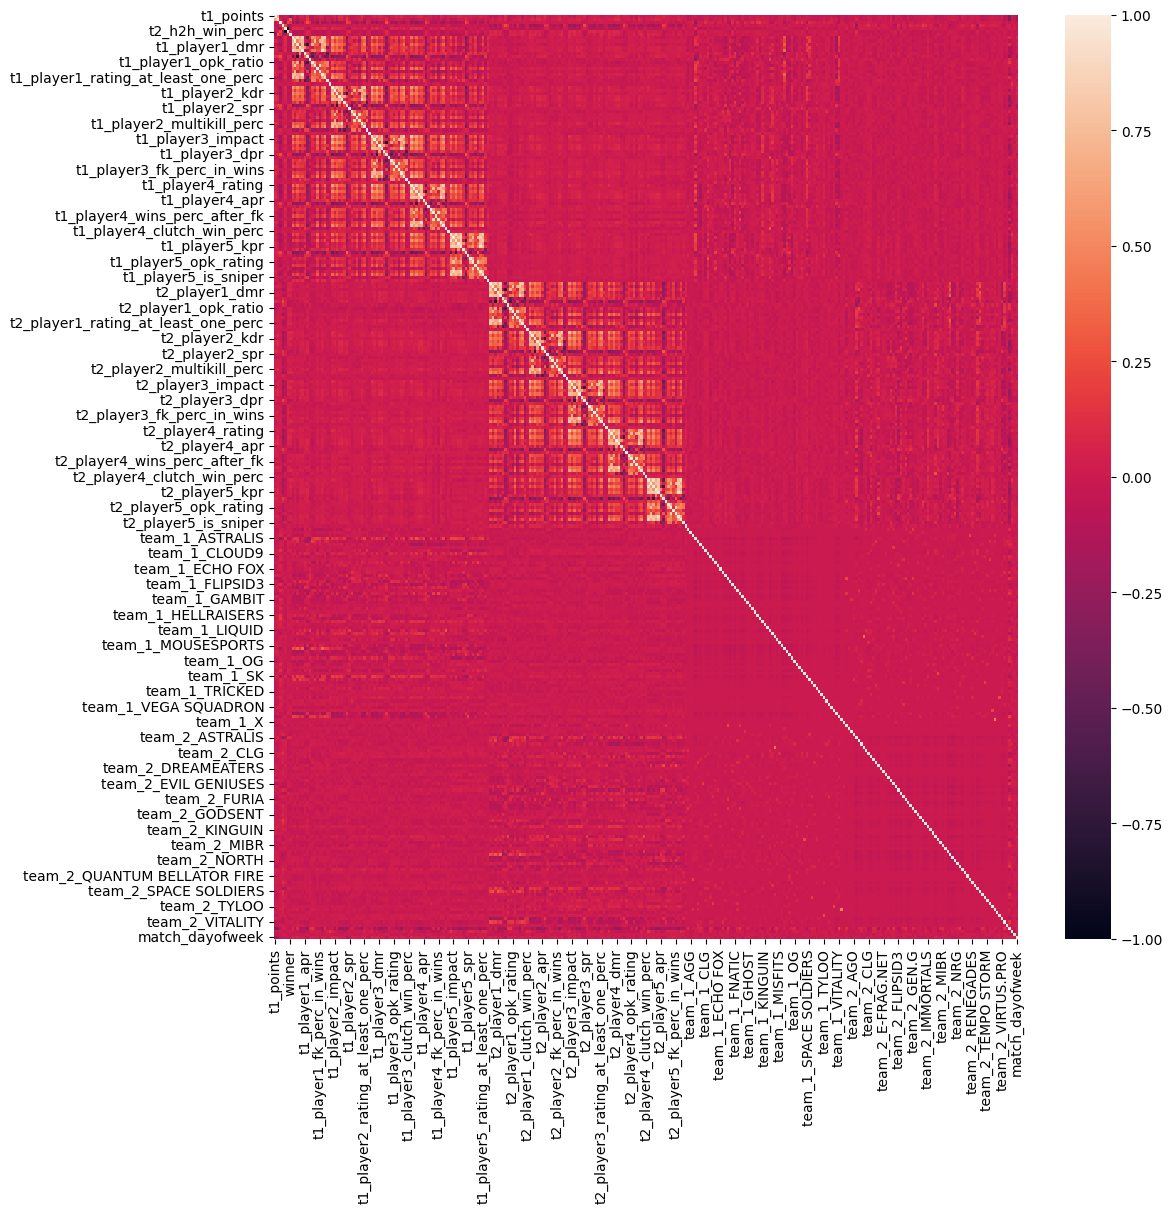

t1_points  t2_points  t1_world_rank  t2_world_rank  \
t1_points         1.000000   0.675230      -0.039732      -0.017611   
t2_points         0.675230   1.000000       0.061266      -0.097104   
t1_world_rank    -0.039732   0.061266       1.000000       0.081617   
t2_world_rank    -0.017611  -0.097104       0.081617       1.000000   
t1_h2h_win_perc   0.016337  -0.068630      -0.239597       0.237277   
...                    ...        ...            ...            ...   
team_2_WINDIGO   -0.040108  -0.041747       0.026744       0.041759   
match_year       -0.357717  -0.346807      -0.054173       0.047517   
match_month       0.003575  -0.002911       0.016191      -0.018492   
match_day        -0.023940  -0.024723      -0.013789       0.019597   
match_dayofweek  -0.199764  -0.208938      -0.020793      -0.019749   

                 t1_h2h_win_perc  t2_h2h_win_perc    winner  \
t1_points               0.016337        -0.016337 -0.282784   
t2_points              -0.068630         0.068630  0.315904   
t1_world_rank          -0.239597         0.239597  0.137199   
t2_world_rank           0.237277        -0.237277 -0.112191   
t1_h2h_win_perc         1.000000        -1.000000 -0.116134   
...                          ...              ...       ...   
team_2_WINDIGO         -0.006927         0.006927 -0.016331   
match_year              0.032673        -0.032673 -0.030907   
match_month            -0.006366         0.006366  0.017598   
match_day               0.019565        -0.019565 -0.002508   
match_dayofweek        -0.000305         0.000305 -0.002815   

                 t1_player1_rating  t1_player1_impact  t1_player1_kdr  ...  \
t1_points                -0.023466           0.064508       -0.048809  ...   
t2_points                -0.098094          -0.003796       -0.111573  ...   
t1_world_rank            -0.210945          -0.087558       -0.281008  ...   
t2_world_rank             0.013872           0.001425        0.002765  ...   
t1_h2h_win_perc           0.119786           0.096800        0.112668  ...   
...                            ...                ...             ...  ...   
team_2_WINDIGO            0.028412           0.013113        0.036165  ...   
match_year                0.106192          -0.097905        0.110793  ...   
match_month               0.018797          -0.014138       -0.016351  ...   
match_day                -0.021201           0.003678       -0.013302  ...   
match_dayofweek           0.072732           0.030925        0.077989  ...   

                 team_2_VALIANCE  team_2_VEGA SQUADRON  team_2_VG.CYBERZEN  \
t1_points              -0.026494              0.017841           -0.018528   
t2_points              -0.006256             -0.000461           -0.013409   
t1_world_rank           0.053171              0.006311            0.032692   
t2_world_rank           0.068937              0.058039            0.026521   
t1_h2h_win_perc        -0.017434             -0.019778            0.015839   
...                          ...                   ...                 ...   
team_2_WINDIGO         -0.001980             -0.001565           -0.000699   
match_year              0.047606              0.010085           -0.020108   
match_month            -0.035906             -0.061847            0.015523   
match_day              -0.006201              0.009209            0.024671   
match_dayofweek         0.029339              0.007320            0.016082   

                 team_2_VIRTUS.PRO  team_2_VITALITY  team_2_WINDIGO  \
t1_points                 0.057918        -0.084721       -0.040108   
t2_points                 0.012890        -0.062979       -0.041747   
t1_world_rank             0.008245        -0.025284        0.026744   
t2_world_rank            -0.070414        -0.061286        0.041759   
t1_h2h_win_perc           0.015081        -0.012482       -0.006927   
...                            ...              ...             ...   
team_2_WINDIGO           -0.008337  

In [21]:
draw_heatmap(df)
df.corr()

Так как признаков слишком много, чтобы выводить полную матрицу кореляции, оставим только значения где корреляция > 0.1

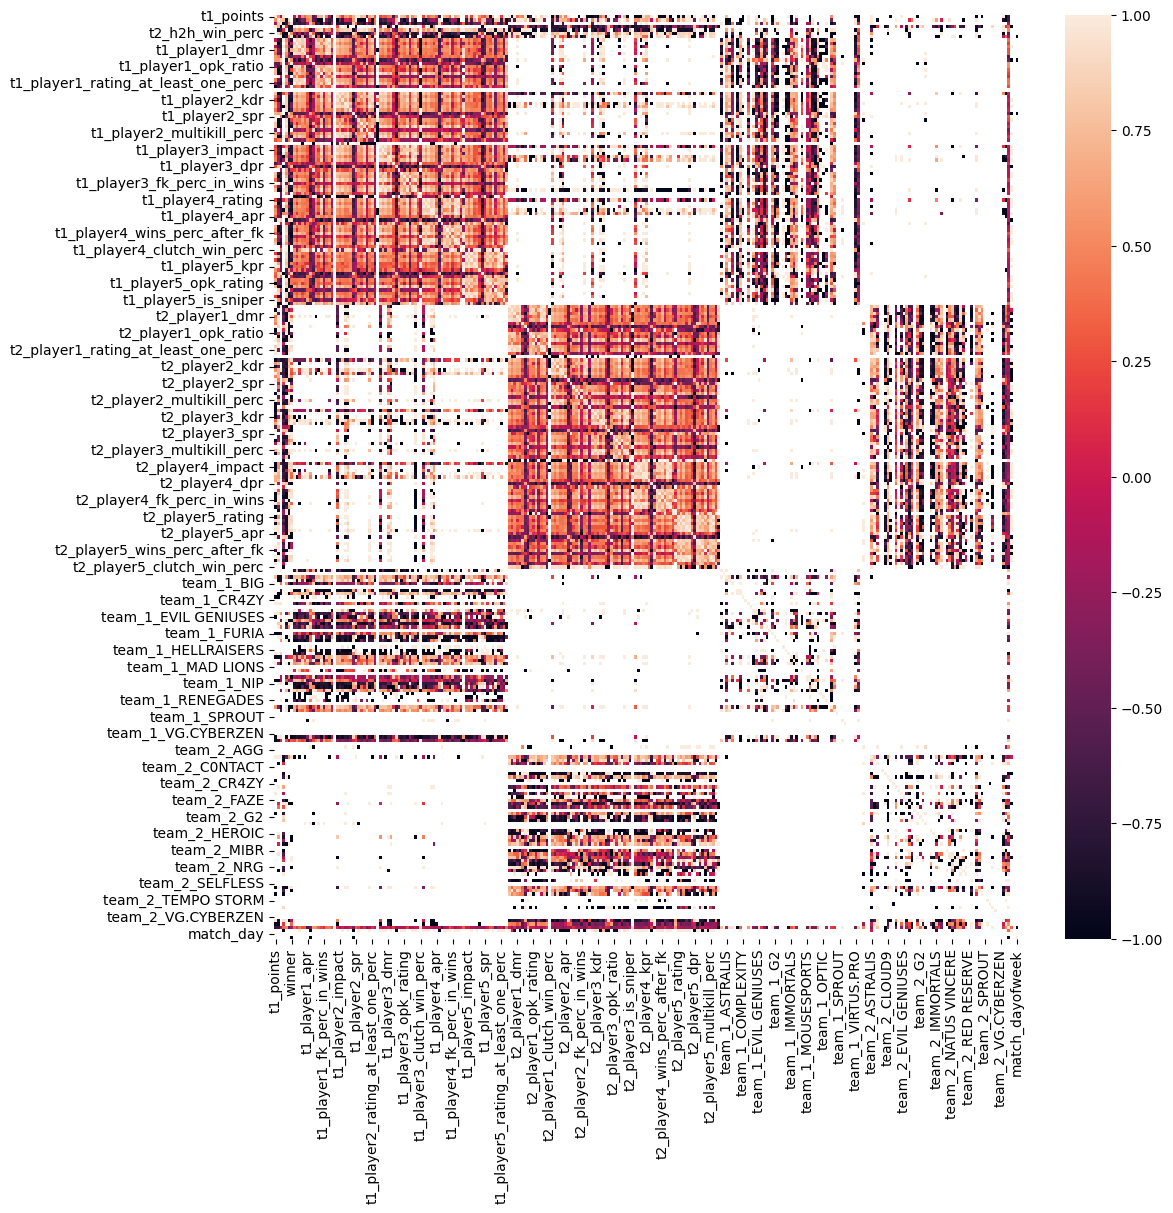

t1_points  t2_points  t1_world_rank  t2_world_rank  \
t1_points              NaN   0.675230            NaN            NaN   
t2_points         0.675230        NaN            NaN            NaN   
t1_world_rank          NaN        NaN            NaN            NaN   
t2_world_rank          NaN        NaN            NaN            NaN   
t1_h2h_win_perc        NaN        NaN      -0.239597       0.237277   
...                    ...        ...            ...            ...   
team_2_VITALITY        NaN        NaN            NaN            NaN   
match_year       -0.357717  -0.346807            NaN            NaN   
match_month            NaN        NaN            NaN            NaN   
match_day              NaN        NaN            NaN            NaN   
match_dayofweek  -0.199764  -0.208938            NaN            NaN   

                 t1_h2h_win_perc  t2_h2h_win_perc    winner  \
t1_points                    NaN              NaN -0.282784   
t2_points                    NaN              NaN  0.315904   
t1_world_rank          -0.239597         0.239597  0.137199   
t2_world_rank           0.237277        -0.237277 -0.112191   
t1_h2h_win_perc              NaN        -1.000000 -0.116134   
...                          ...              ...       ...   
team_2_VITALITY              NaN              NaN       NaN   
match_year                   NaN              NaN       NaN   
match_month                  NaN              NaN       NaN   
match_day                    NaN              NaN       NaN   
match_dayofweek              NaN              NaN       NaN   

                 t1_player1_rating  t1_player1_impact  t1_player1_kdr  ...  \
t1_points                      NaN                NaN             NaN  ...   
t2_points                      NaN                NaN       -0.111573  ...   
t1_world_rank            -0.210945                NaN       -0.281008  ...   
t2_world_rank                  NaN                NaN             NaN  ...   
t1_h2h_win_perc           0.119786                NaN        0.112668  ...   
...                            ...                ...             ...  ...   
team_2_VITALITY                NaN                NaN             NaN  ...   
match_year                0.106192                NaN        0.110793  ...   
match_month                    NaN                NaN             NaN  ...   
match_day                      NaN                NaN             NaN  ...   
match_dayofweek                NaN                NaN             NaN  ...   

                 team_2_TYLOO  team_2_VALIANCE  team_2_VEGA SQUADRON  \
t1_points                 NaN              NaN                   NaN   
t2_points                 NaN              NaN                   NaN   
t1_world_rank             NaN              NaN                   NaN   
t2_world_rank             NaN              NaN                   NaN   
t1_h2h_win_perc           NaN              NaN                   NaN   
...                       ...              ...                   ...   
team_2_VITALITY           NaN              NaN                   NaN   
match_year                NaN              NaN                   NaN   
match_month               NaN              NaN                   NaN   
match_day                 NaN              NaN                   NaN   
match_dayofweek           NaN              NaN                   NaN   

                 team_2_VG.CYBERZEN  team_2_VIRTUS.PRO  team_2_VITALITY  \
t1_points                       NaN                NaN              NaN   
t2_points                       NaN                NaN              NaN   
t1_world_rank                   NaN                NaN              NaN   
t2_world_rank                   NaN                NaN              NaN   
t1_h2h_win_perc                 NaN                NaN              NaN   
...                             ...                ...              ...   
team_2_VITALITY                 NaN                NaN              NaN   
match

In [22]:
res = (
    df.corr()
    .where(lambda x: (abs(x) > 0.1) & (abs(x) != 1.0))
    .dropna(axis=1, how="all")
    .dropna(axis=0, how="all")
)
draw_heatmap(res)
res

Между параметрами одной команды есть сильная кореляция.

Между параметрами разных команд кореляция слабая.

### Выбор целевой переменной

Так как все параметры в датасете - метрики, вычисленные по итогу матча, то предсказывать по ним победу / поражение не имеет смысла.

Вместо этого, будем считать "оценки" команд.

Для этого создадим колонки `t{n}_weighted_raiting`, отражающие средневзвешенный рейтинг команды с учетом вклада игроков.

In [23]:
def calculate_weighted_rating(row, team_prefix):
    ratings = [row[f"{team_prefix}_player{i}_rating"] for i in range(1, 6)]
    impacts = [row[f"{team_prefix}_player{i}_impact"] for i in range(1, 6)]

    weights = []
    for i in range(5):
        weight = impacts[i]
        weights.append(weight)

    total_weight = sum(weights)
    if total_weight > 0:
        normalized_weights = [w / total_weight for w in weights]
    else:
        normalized_weights = [0.2] * 5

    weighted_rating = sum(r * w for r, w in zip(ratings, normalized_weights))

    return weighted_rating

In [24]:
df["t1_weighted_rating"] = df.apply(
    lambda x: calculate_weighted_rating(x, "t1"), axis=1
)
df["t2_weighted_rating"] = df.apply(
    lambda x: calculate_weighted_rating(x, "t2"), axis=1
)

In [25]:
df.drop([f"t1_player{i}_rating" for i in range(1, 6)], axis=1, inplace=True)
df.drop([f"t1_player{i}_impact" for i in range(1, 6)], axis=1, inplace=True)

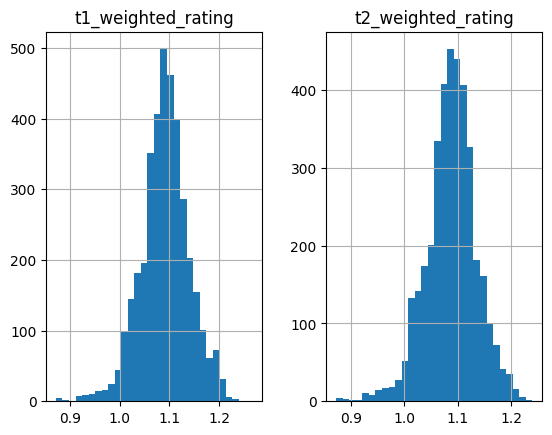

In [26]:
df[["t1_weighted_rating", "t2_weighted_rating"]].hist(bins=30)
plt.show()

In [27]:
# Стандартизуем данные, так как есть выбросы
df = (df - df.mean()) / df.std()

In [28]:
target_col = "t1_weighted_rating"

In [29]:
for col in df.columns:
    print(f"corr for {col} column: {np.abs(df[target_col].corr(df[col]))}")

corr for t1_points column: 0.02213888467494238
corr for t2_points column: 0.08357331972573759
corr for t1_world_rank column: 0.2809291659175511
corr for t2_world_rank column: 0.00018857630109992443
corr for t1_h2h_win_perc column: 0.14050017095530762
corr for t2_h2h_win_perc column: 0.14050017095530765
corr for winner column: 0.12270058796504911
corr for t1_player1_kdr column: 0.6821167815053487
corr for t1_player1_dmr column: 0.44426597541736484
corr for t1_player1_kpr column: 0.5670014153106567
corr for t1_player1_apr column: 0.08792921510375275
corr for t1_player1_dpr column: 0.5090214618089783
corr for t1_player1_spr column: 0.005720936347032594
corr for t1_player1_opk_ratio column: 0.3732616245509512
corr for t1_player1_opk_rating column: 0.29792047997761534
corr for t1_player1_wins_perc_after_fk column: 0.4820452054413405
corr for t1_player1_fk_perc_in_wins column: 0.08951579317828673
corr for t1_player1_multikill_perc column: 0.5079284055168084
corr for t1_player1_rating_at_leas

Есть много слабо коррелирующих фич

In [30]:
features = []

for col in df.columns:
    if np.abs(df[target_col].corr(df[col])) > 0.15:
        features.append(col)

features

['t1_world_rank',
 't1_player1_kdr',
 't1_player1_dmr',
 't1_player1_kpr',
 't1_player1_dpr',
 't1_player1_opk_ratio',
 't1_player1_opk_rating',
 't1_player1_wins_perc_after_fk',
 't1_player1_multikill_perc',
 't1_player1_rating_at_least_one_perc',
 't1_player2_kdr',
 't1_player2_dmr',
 't1_player2_kpr',
 't1_player2_apr',
 't1_player2_dpr',
 't1_player2_opk_ratio',
 't1_player2_opk_rating',
 't1_player2_wins_perc_after_fk',
 't1_player2_multikill_perc',
 't1_player2_rating_at_least_one_perc',
 't1_player3_kdr',
 't1_player3_dmr',
 't1_player3_kpr',
 't1_player3_dpr',
 't1_player3_opk_ratio',
 't1_player3_opk_rating',
 't1_player3_wins_perc_after_fk',
 't1_player3_multikill_perc',
 't1_player3_rating_at_least_one_perc',
 't1_player4_kdr',
 't1_player4_dmr',
 't1_player4_kpr',
 't1_player4_dpr',
 't1_player4_opk_ratio',
 't1_player4_opk_rating',
 't1_player4_wins_perc_after_fk',
 't1_player4_multikill_perc',
 't1_player4_rating_at_least_one_perc',
 't1_player5_kdr',
 't1_player5_dmr',
 

In [31]:
df_new = df[features]
df_new.shape

(3787, 52)

## Разделение данных

In [32]:
X, Y = df_new.drop(target_col, axis=1), df_new[target_col]
X, Y = X.values, Y.values

x_train, x_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42
)



x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)

# 2. Реализация и обучение базовой RBF

## Создание классов и функция

In [33]:
class RBFLayer(Layer):
    def __init__(
        self, num_centers, rbf_type="gaussian", init_method="kmeans", **kwargs
    ):

        super(RBFLayer, self).__init__(**kwargs)

        self.num_centers = num_centers
        self.rbf_type = rbf_type
        self.init_method = init_method

    def build(self, input_shape):
        # инициализация центров
        if self.init_method == "kmeans":
            kmeans = KMeans(n_clusters=self.num_centers, random_state=42)
            kmeans.fit(x_train)
            initial_centers = kmeans.cluster_centers_
        else:
            idx = np.random.choice(x_train.shape[0], self.num_centers, replace=False)
            initial_centers = x_train[idx]

        self.centers = self.add_weight(
            name="centers",
            shape=(self.num_centers, input_shape[-1]),
            initializer=tf.constant_initializer(initial_centers),
            trainable=False,
        )

        # инициализация ширины
        distances = initial_centers[:, np.newaxis]
        distances = distances - initial_centers
        distances = distances**2
        distances = distances.sum(axis=2)
        distances = np.sqrt(distances)

        avg_distances = np.mean(distances, axis=1)
        initial_sigmas = avg_distances / np.sqrt(2 * self.num_centers)

        self.sigmas = self.add_weight(
            name="sigmas",
            shape=(self.num_centers,),
            initializer=tf.constant_initializer(initial_sigmas),
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - tf.expand_dims(self.centers, 0)
        distances = tf.reduce_sum(tf.square(diff), axis=-1)

        if self.rbf_type == "gaussian":
            return tf.exp(-distances / (2 * tf.square(self.sigmas) + 1e-10))
        elif self.rbf_type == "multiquadric":
            return tf.sqrt(distances + tf.square(self.sigmas))
        elif self.rbf_type == "inverse_quadratic":
            return 1.0 / (tf.sqrt(distances) + tf.square(self.sigmas) + 1e-10)
        else:
            raise ValueError("Нет такого")

In [34]:
def create_rbf_model(num_centers=20, rbf_type="gaussian", init_method="kmeans"):
    model = Sequential(
        [
            RBFLayer(num_centers, rbf_type=rbf_type, init_method=init_method),
            Dense(1, activation="sigmoid"),
        ]
    )
    return model

In [35]:
def train_pseudo_inverse(model, X, y):  # регрессия
    start_time = time.time()

    rbf_model = Sequential([model.layers[0]])
    rbf_features = rbf_model.predict(X, verbose=0)

    y_reshaped = (
        y.values.reshape(-1, 1) if isinstance(y, pd.Series) else y.reshape(-1, 1)
    )
    W = pinv(rbf_features) @ y_reshaped

    output_layer = model.layers[1]
    output_layer.build((None, model.layers[0].num_centers))

    output_layer.set_weights([W, np.array([0.0])])

    model.layers[0].trainable = False

    return time.time() - start_time


def train_gradient_descent(model, X, y, epochs=50, lr=0.01, batch_size=32):  # градиент
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae", "mse"],
    )
    start_time = time.time()

    history = model.fit(
        X,
        y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=0,
    )
    return history, time.time() - start_time

In [36]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X, verbose=0)
    return {
        "rmse": root_mean_squared_error(y, y_pred),
        "mae": mean_absolute_error(y, y_pred),
        "r2": r2_score(y, y_pred),
    }
    # average = "weighted"

## Оценка

In [37]:
results = []

for init_method in ["kmeans", "random"]:
    for rbf_type in ["gaussian", "multiquadric", "inverse_quadratic"]:

        model_pinv = create_rbf_model(rbf_type=rbf_type, init_method=init_method)
        train_time = train_pseudo_inverse(model_pinv, x_train, y_train)
        metrics = evaluate_model(model_pinv, x_val, y_val)
        results.append(
            {
                "init": init_method,
                "rbf": rbf_type,
                "time": train_time,
                "train": "pseudo_inverse",
                **metrics,
            }
        )

        model_gd = create_rbf_model(rbf_type=rbf_type, init_method=init_method)
        history, train_time = train_gradient_descent(model_gd, x_train, y_train)
        metrics = evaluate_model(model_gd, x_val, y_val)
        results.append(
            {
                "init": init_method,
                "rbf": rbf_type,
                "time": train_time,
                "train": "gradient_descent",
                **metrics,
            }
        )

results_df = pd.DataFrame(results)
results_df

init                rbf      time             train      rmse       mae  \
0   kmeans           gaussian  1.412421    pseudo_inverse  1.144312  0.896912   
1   kmeans           gaussian  8.734946  gradient_descent  0.846538  0.588731   
2   kmeans       multiquadric  0.221726    pseudo_inverse  1.011417  0.791700   
3   kmeans       multiquadric  8.924053  gradient_descent  0.844772  0.585372   
4   kmeans  inverse_quadratic  0.233010    pseudo_inverse  1.018668  0.797617   
5   kmeans  inverse_quadratic  9.184745  gradient_descent  0.864620  0.604212   
6   random           gaussian  0.183856    pseudo_inverse  1.170214  0.917934   
7   random           gaussian  8.694006  gradient_descent  0.847066  0.588810   
8   random       multiquadric  0.199359    pseudo_inverse  1.013560  0.796413   
9   random       multiquadric  8.570051  gradient_descent  0.846473  0.578146   
10  random  inverse_quadratic  0.197474    pseudo_inverse  1.022282  0.800946   
11  random  inverse_quadratic  8.888178  gradient_descent  0.874677  0.622005   

          r2  
0  -0.231250  
1   0.326170  
2   0.038127  
3   0.328979  
4   0.024287  
5   0.297078  
6  -0.287619  
7   0.325329  
8   0.034048  
9   0.326273  
10  0.017350  
11  0.280629

In [38]:
def print_grouped_metrics(group_by, metrics=["rmse", "mae", "r2"]):
    grouped = results_df.groupby(group_by)

    mean_metrics = grouped.mean(numeric_only=True).reset_index()

    plt.figure(figsize=(14, 8))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, len(metrics), i)

        sns.barplot(data=mean_metrics, x=group_by, y=metric, palette="viridis")

        plt.title(f"сравнение {metric}")
        plt.ylabel(metric.upper())

    plt.tight_layout()
    plt.show()

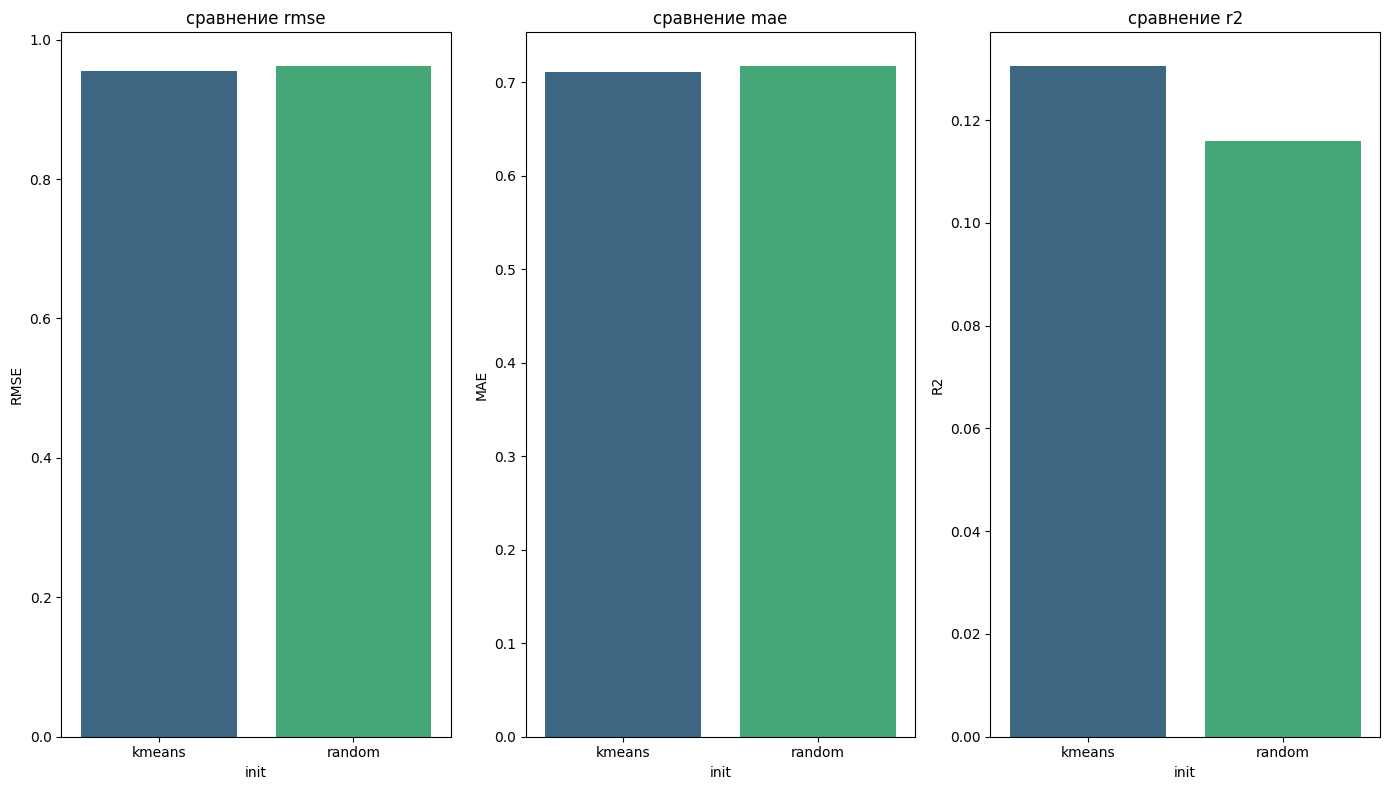

In [39]:
print_grouped_metrics("init")

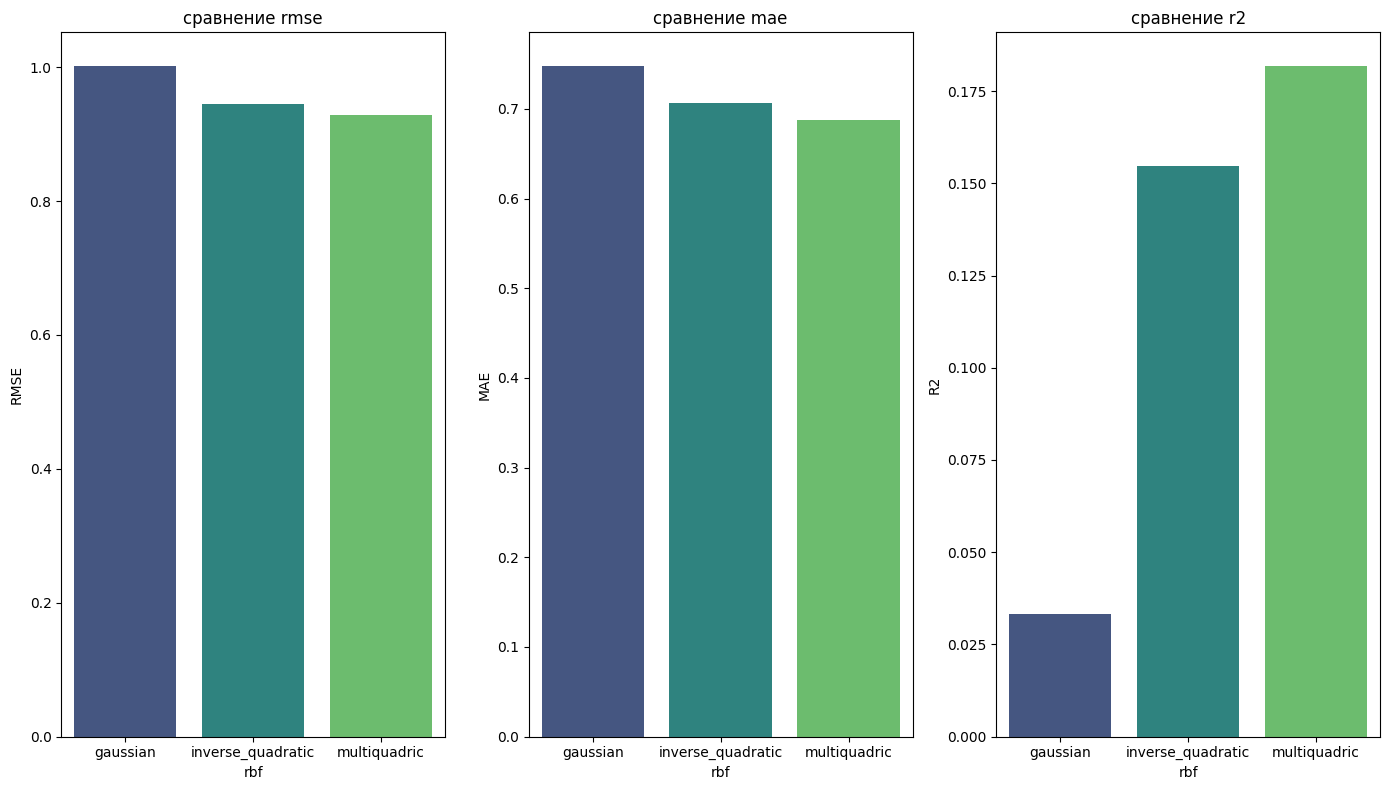

In [40]:
print_grouped_metrics("rbf")

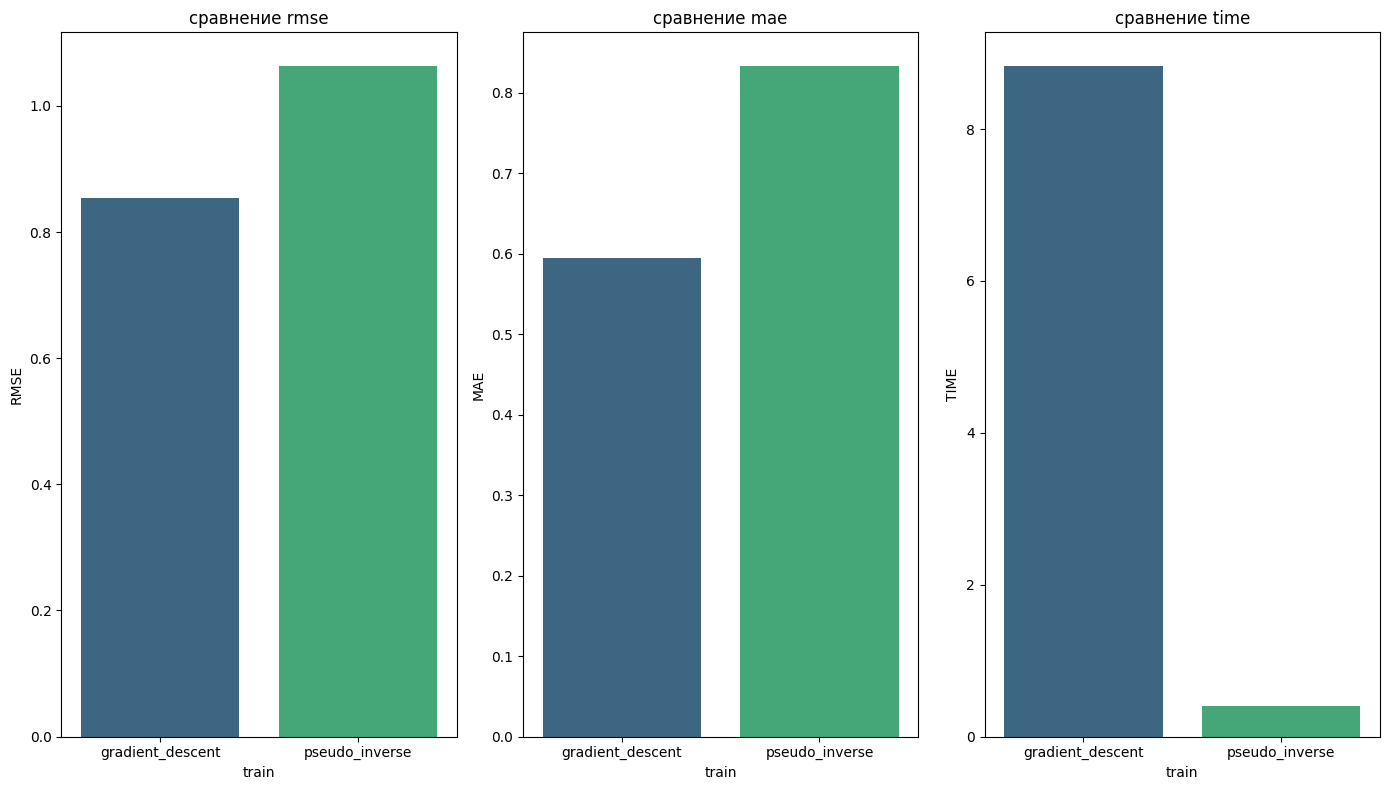

In [41]:
print_grouped_metrics("train", ["rmse", "mae", "time"])

**Наилучший результат показывают:**
1. Инициализация с помощью k means
2. inverse multiquadric rbf
3. Обучение градиентным спуском на мини батчах

Однако, стоит отметить, что градиентный спуск для достижения хорошей точности, тредует больше времени на обучение

In [42]:
# Тестирование лучшей модели на тестовых данных
best_model = create_rbf_model(rbf_type="inverse_quadratic", init_method="kmeans")
train_gradient_descent(best_model, x_train, y_train, epochs=50)
test_metrics = evaluate_model(best_model, x_test, y_test)

In [43]:
print("Результаты на тестовых данных:")
print(pd.Series(test_metrics))

Результаты на тестовых данных:
rmse    0.741982
mae     0.522597
r2      0.408547
dtype: float64


# 3. Проклятие размерности

In [44]:
df.shape

(3787, 293)

In [45]:
feature_counts = list(range(5, 201, 5))
results = {"n": [], "rmse": [], "r2": [], "mae": [], "time": []}

for n_features in feature_counts:
    print(n_features, end=" ")

    feature = np.random.choice(df.columns[:-1], size=n_features, replace=False)
    X = df[list(feature)].values

    x_train, x_temp, y_train, y_temp = train_test_split(
        X, Y, test_size=0.3, random_state=42
    )

    x_val, x_test, y_val, y_test = train_test_split(
        x_temp, y_temp, test_size=0.5, random_state=42
    )

    model = create_rbf_model(
        num_centers=20, rbf_type="multiquadric", init_method="kmeans"
    )
    train_time = train_pseudo_inverse(model, x_train, y_train)

    metrics = evaluate_model(model, x_val, y_val)

    results["n"].append(n_features)
    results["time"].append(train_time)
    results["rmse"].append(metrics["rmse"])
    results["mae"].append(metrics["mae"])
    results["r2"].append(metrics["r2"])

5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 

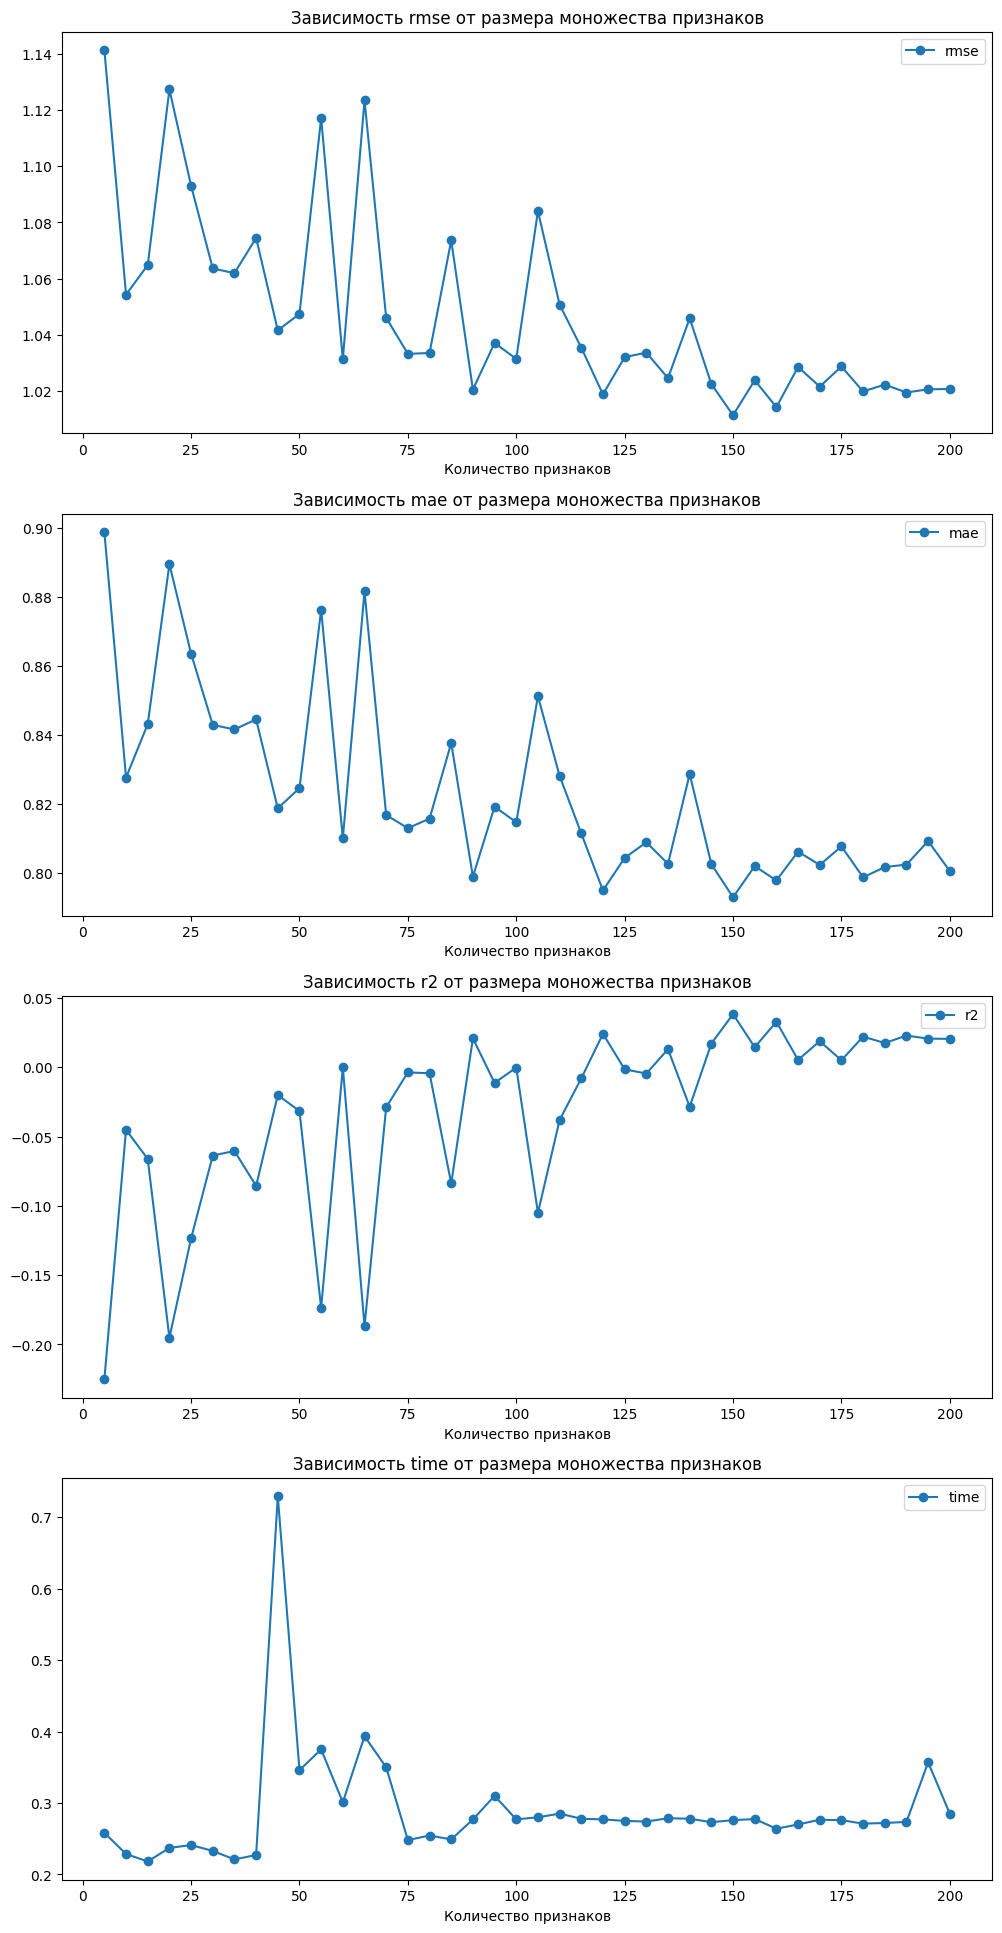

In [46]:
plt.figure(figsize=(12, 24))

for _, name in enumerate(["rmse", "mae", "r2", "time"]):
    plt.subplot(4, 1, _ + 1)

    plt.title(f"Зависимость {name} от размера моножества признаков")

    plt.plot(results["n"], results[name], label=name, marker="o")

    plt.xlabel("Количество признаков")

    plt.legend()

plt.show()

In [47]:
nums_centers = list(range(5, 201, 5))
results = {"n": [], "rmse": [], "r2": [], "mae": [], "time": []}

X = df_new.values

x_train, x_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)

for num_centers in nums_centers:
    print(num_centers, end=" ")

    model = create_rbf_model(
        num_centers=num_centers, rbf_type="multiquadric", init_method="kmeans"
    )
    train_time = train_pseudo_inverse(model, x_train, y_train)

    metrics = evaluate_model(model, x_val, y_val)

    results["n"].append(num_centers)
    results["time"].append(train_time)
    results["rmse"].append(metrics["rmse"])
    results["mae"].append(metrics["mae"])
    results["r2"].append(metrics["r2"])

5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 

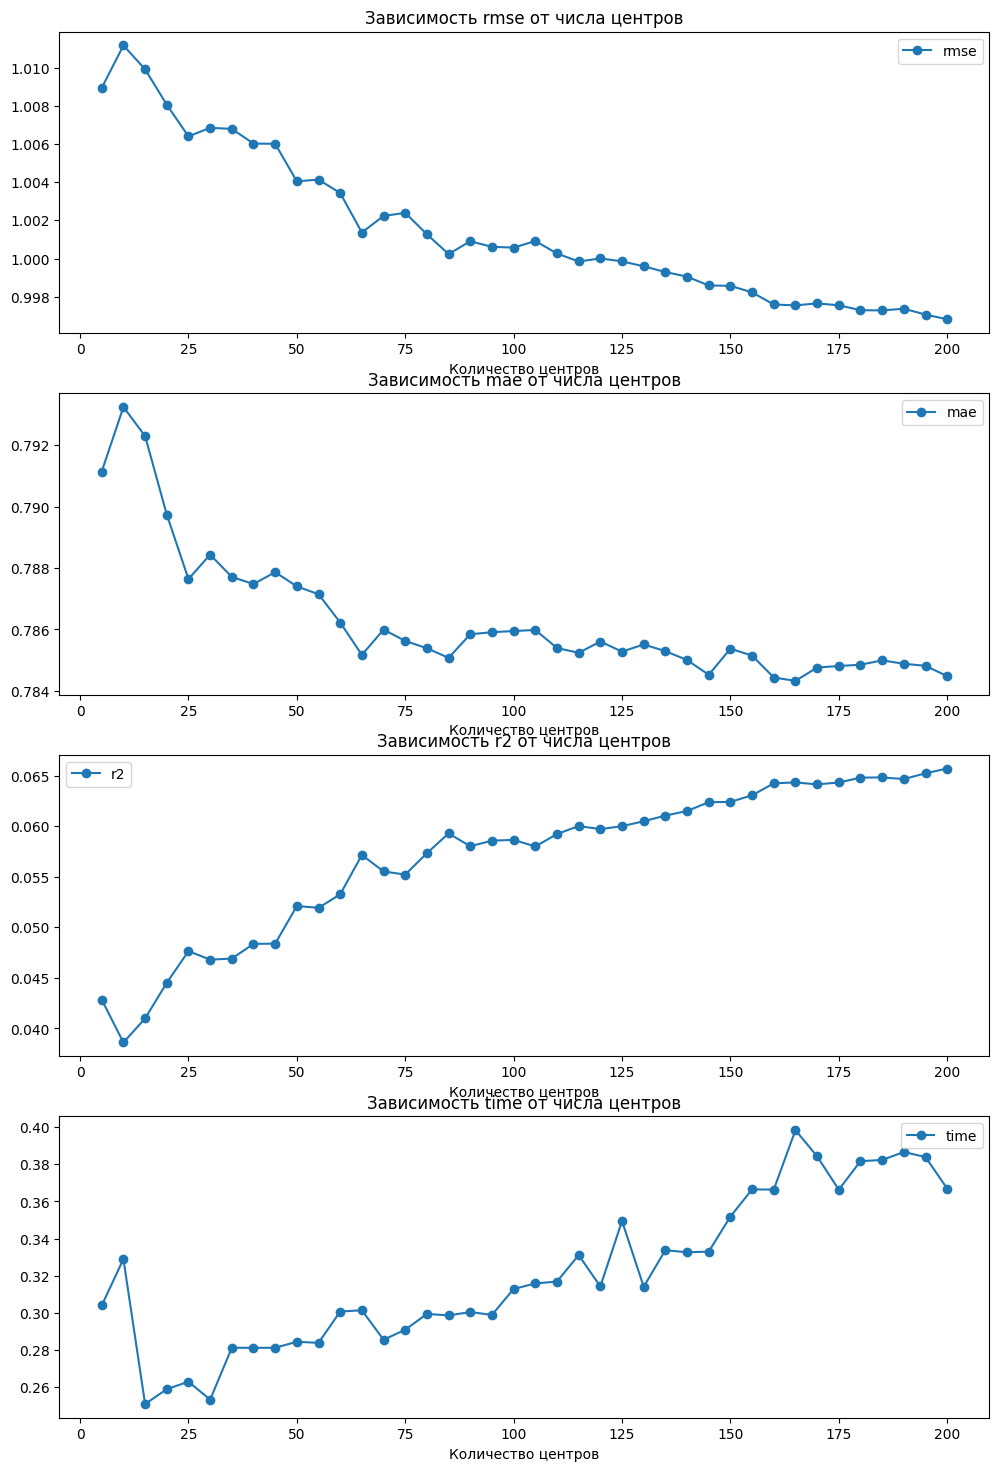

In [48]:
plt.figure(figsize=(12, 18))

for _, name in enumerate(["rmse", "mae", "r2", "time"]):
    plt.subplot(4, 1, _ + 1)

    plt.title(f"Зависимость {name} от числа центров")

    plt.plot(results["n"], results[name], label=name, marker="o")

    plt.xlabel("Количество центров")

    plt.legend()

plt.show()

Проклятия размерности не наблюдается

Возможно, для данной задачи хватает данных даже для столь большого количества признаков.

Также причиной может быть сильная корреляция целевой переменной с фичами.

# 4. Оптимизация модели

## Гибридная модель

### Создание

In [49]:
def create_hybrid_model(
    num_centers=50,
    rbf_type="multiquadric",
    mlp_layers=[64, 32],
    activation="relu",
    l2_reg=0.001,
):


    inputs = Input(shape=(x_train.shape[1],))


    rbf_layer = RBFLayer(num_centers, rbf_type=rbf_type, init_method="kmeans")(inputs)


    direct_features = Dense(x_train.shape[1], activation="linear")(inputs)


    x = Concatenate()([rbf_layer, direct_features])


    for units in mlp_layers:

        x = Dense(units, activation=activation, kernel_regularizer=l2(l2_reg))(x)


    outputs = Dense(1)(x)


    model = Model(inputs=inputs, outputs=outputs)
    return model

In [50]:
hybrid_model = create_hybrid_model(
    num_centers=30, mlp_layers=[128, 64, 32], activation="swish", l2_reg=0.01
)

hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

### Тестирование

In [51]:
history = hybrid_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1,
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.9421 - mae: 0.6161 - val_loss: 1.9525 - val_mae: 0.1995
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8455 - mae: 0.2030 - val_loss: 1.5887 - val_mae: 0.1654
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5156 - mae: 0.1690 - val_loss: 1.3365 - val_mae: 0.1529
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2847 - mae: 0.1443 - val_loss: 1.1743 - val_mae: 0.1908
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1242 - mae: 0.1435 - val_loss: 1.0350 - val_mae: 0.1628
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9959 - mae: 0.1200 - val_loss: 0.9216 - val_mae: 0.1218
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8968 - mae: 0.1088 - val_loss: 0.8313 - val_mae: 0.0810
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8131 - mae: 0.0788 - val_loss: 0.7624 - val_mae: 0.0662
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.747

In [52]:
rmse = root_mean_squared_error(hybrid_model.predict(x_test), y_test)
r2 = r2_score(hybrid_model.predict(x_test), y_test)
print(f"RMSE: {rmse:.4f}, R2: {r2}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 0.0254, R2: 0.9992961724408553


Комбинированная модель кратно лучше

## Ускорение обучения

### Инициализация моделей

#### mini-batch k-means

In [53]:
class MiniBatchRBFLayer(RBFLayer):
    def build(self, input_shape):
        kmeans = MiniBatchKMeans(
            n_clusters=self.num_centers, random_state=42, batch_size=1024
        )
        kmeans.fit(x_train)
        initial_centers = kmeans.cluster_centers_


        self.centers = self.add_weight(
            name="centers",

            shape=(self.num_centers, input_shape[-1]),
            initializer=tf.constant_initializer(initial_centers),
            trainable=False,
        )


        distances = initial_centers[:, np.newaxis]
        distances = distances - initial_centers

        distances = distances**2
        distances = distances.sum(axis=2)
        distances = np.sqrt(distances)


        avg_distances = np.mean(distances, axis=1)
        initial_sigmas = avg_distances / np.sqrt(2 * self.num_centers)


        self.sigmas = self.add_weight(
            name="sigmas",
            shape=(self.num_centers,),
            initializer=tf.constant_initializer(initial_sigmas),
            trainable=True,
        )

#### KD-деревья

In [54]:
class KDRBFLayer(Layer):
    def __init__(self, num_centers, **kwargs):
        super(KDRBFLayer, self).__init__(**kwargs)
        self.num_centers = num_centers

    def build(self, input_shape):
        kmeans = KMeans(n_clusters=self.num_centers, random_state=42)
        kmeans.fit(x_train.numpy() if tf.is_tensor(x_train) else x_train)
        self.centers = self.add_weight(
            name="centers",
            shape=(self.num_centers, input_shape[-1]),
            initializer=tf.constant_initializer(kmeans.cluster_centers_),
            trainable=False,
        )

        distances = kmeans.cluster_centers_[:, np.newaxis]
        distances = distances - kmeans.cluster_centers_
        distances = distances**2
        distances = distances.sum(axis=2)
        distances = np.sqrt(distances)

        avg_distances = np.mean(distances, axis=1)
        self.sigmas = self.add_weight(
            name="sigmas",
            shape=(self.num_centers,),
            initializer=tf.constant_initializer(
                avg_distances / np.sqrt(2 * self.num_centers)
            ),
            trainable=True,
        )

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - tf.expand_dims(self.centers, 0)
        squared_dist = tf.reduce_sum(tf.square(diff), axis=-1)

        _, indices = tf.math.top_k(-squared_dist, k=min(5, self.num_centers))

        batch_size = tf.shape(inputs)[0]
        rows = tf.repeat(tf.range(batch_size), min(5, self.num_centers))
        cols = tf.reshape(indices, [-1])
        updates = tf.ones(tf.shape(rows)[0])
        mask = tf.scatter_nd(
            tf.stack([rows, cols], axis=1), updates, [batch_size, self.num_centers]
        )

        rbf = tf.exp(-squared_dist / (2 * tf.square(self.sigmas)))
        return rbf * mask

#### Рандомизированная SDV

In [59]:
def train_pseudo_inverse_fast(model, X, y, n_components=None, n_oversamples=10):

    rbf_layer = model.layers[0]
    rbf_model = Sequential([rbf_layer])

    rbf_features = rbf_model.predict(X, verbose=0)

    if n_components is None:
        n_components = min(rbf_features.shape[1] // 2, 100)
        n_components = max(n_components, 1)

    U, s, Vh = randomized_svd(
        rbf_features,
        n_components=n_components,
        n_oversamples=n_oversamples,
        random_state=42,
    )

    s_inv = np.zeros_like(s)
    s_inv[s > 1e-10] = 1 / s[s > 1e-10]
    W = Vh.T @ np.diag(s_inv) @ U.T @ y.reshape(-1, 1)

    if len(model.layers) > 1:
        output_layer = model.layers[1]
        output_layer.build((None, rbf_layer.num_centers))
        output_layer.set_weights([W, np.array([0.0])])

    return model

#### Сравнение

In [60]:
x_sample, y_sample = x_train, y_train


def evaluate_method(method_func, method_name):
    start_time = time.time()
    model = method_func(x_sample, y_sample)
    train_time = time.time() - start_time

    y_pred = model.predict(x_val, verbose=0)
    rmse = root_mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    return {
        "Метод": method_name,
        "Время": train_time,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    }


def baseline_train(X, y):
    model = Sequential([RBFLayer(50), Dense(1)])
    train_pseudo_inverse(model, X, y)
    return model


def minibatch_kmean_train(X, y):
    model = Sequential([MiniBatchRBFLayer(50), Dense(1)])
    train_pseudo_inverse(model, X, y)
    return model


def kdtree_train(X, y):
    model = Sequential([KDRBFLayer(50), Dense(1)])
    train_pseudo_inverse(model, X, y)
    return model


def sdv_train(X, y):
    model = Sequential([RBFLayer(50), Dense(1)])
    train_pseudo_inverse_fast(model, X, y)
    return model


methods = [
    (baseline_train, "Базовая RBF"),
    (minibatch_kmean_train, "MiniBatch KMean"),
    (kdtree_train, "KD-Tree"),
    (sdv_train, "SDV ускорение"),
]

results = []
for func, name in methods:
    print(f"Тестируем {name}...")
    results.append(evaluate_method(func, name))

results = pd.DataFrame(results)
results

Тестируем Базовая RBF...
Тестируем MiniBatch KMean...
Тестируем KD-Tree...
Тестируем SDV ускорение...


Метод     Время      RMSE       MAE        R2
0      Базовая RBF  0.270286  0.981293  0.748158  0.094570
1  MiniBatch KMean  0.402338  1.006735  0.755269  0.047012
2          KD-Tree  0.389512  0.981293  0.748156  0.094570
3    SDV ускорение  0.272775  0.983135  0.751493  0.091169

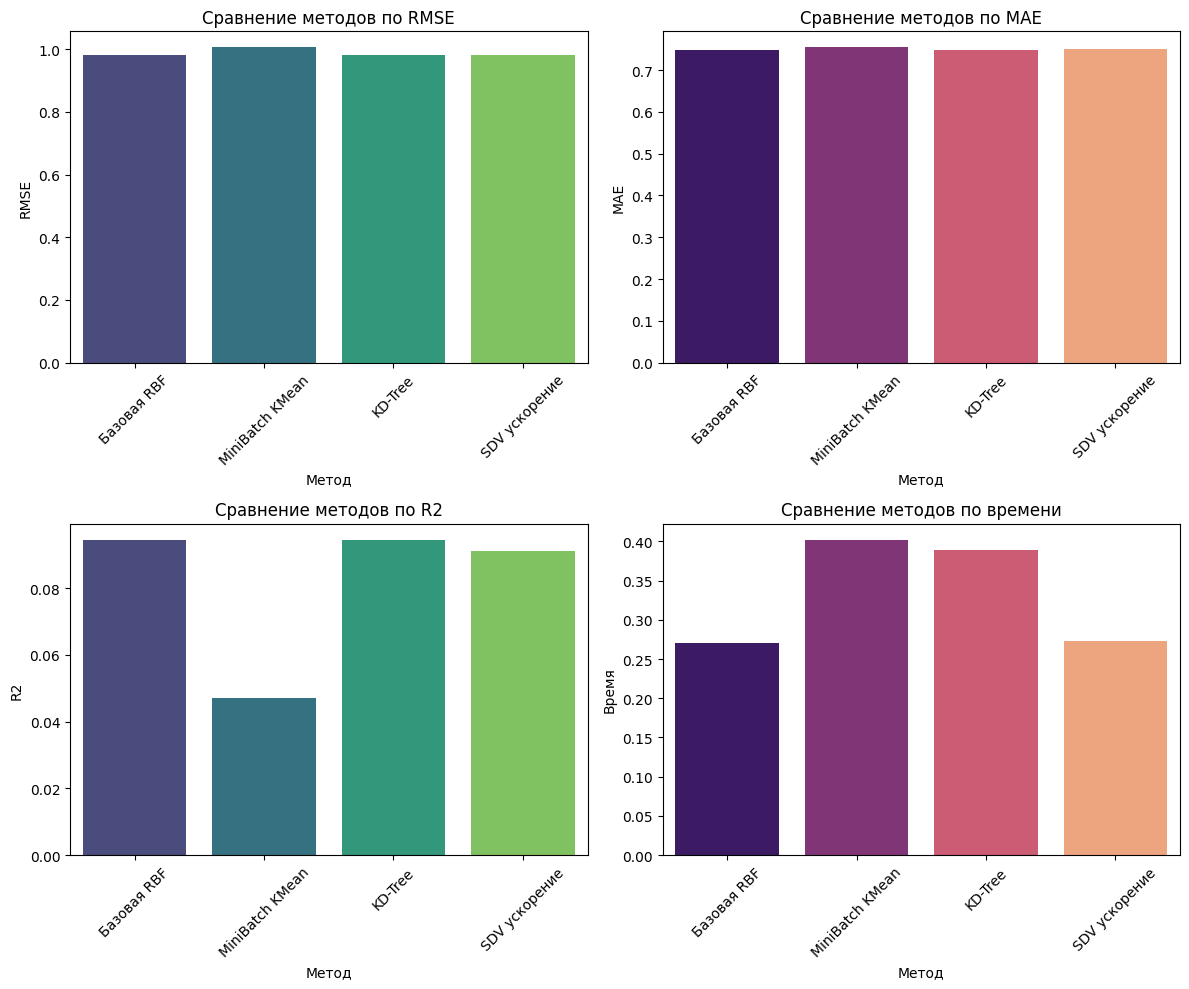

In [61]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.barplot(x=results["Метод"], y=results["RMSE"], palette="viridis")
plt.title("Сравнение методов по RMSE")
plt.xticks(rotation=45)
plt.ylabel("RMSE")

plt.subplot(2, 2, 2)
sns.barplot(x=results["Метод"], y=results["MAE"], palette="magma")
plt.title("Сравнение методов по MAE")
plt.xticks(rotation=45)
plt.ylabel("MAE")

plt.subplot(2, 2, 3)
sns.barplot(x=results["Метод"], y=results["R2"], palette="viridis")
plt.title("Сравнение методов по R2")
plt.xticks(rotation=45)
plt.ylabel("R2")

plt.subplot(2, 2, 4)
sns.barplot(x=results["Метод"], y=results["Время"], palette="magma")
plt.title("Сравнение методов по времени")
plt.xticks(rotation=45)
plt.ylabel("Время")

plt.tight_layout()
plt.show()

Оптимизация позволяет ускорить обучение пожертвовав качеством

## Подбор гиперпараметров

### Инициализация

In [62]:
def create_hybrid_model(
    num_centers=20,
    rbf_type="gaussian",
    init_method="kmeans",
    mlp_layers=[64, 32],
    activation="relu",
    dropout_rate=0.2,
    l2_reg=0.001,
    output_units=1,
    output_activation=None,
):

    inputs = Input(shape=(x_train.shape[1],))

    rbf_layer = RBFLayer(num_centers, rbf_type=rbf_type, init_method=init_method)(
        inputs
    )

    direct_path = Dense(
        x_train.shape[1], activation="linear", kernel_regularizer=l2(l2_reg)
    )(inputs)

    concatenated = Concatenate()([rbf_layer, direct_path])

    x = concatenated
    for units in mlp_layers:
        x = Dense(units, activation=activation, kernel_regularizer=l2(l2_reg))(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(output_units, activation=output_activation)(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [63]:
param_dist = {
    "num_centers": randint(20, 150),
    "rbf_type": ["multiquadric"],
    "mlp_layers": randint(1, 5),
    "units": randint(32, 512),
    "activation": ["relu", "leaky_relu"],
    "dropout_rate": uniform(0.0, 0.5),
    "l2_reg": loguniform(1e-5, 1e-1),
    "learning_rate": loguniform(1e-4, 1e-2),
    "batch_size": [32],
}

n_iter = 5
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))


def train_evaluate_model(params, x_train, y_train, x_val, y_val):
    model = create_hybrid_model(
        num_centers=params["num_centers"],
        rbf_type=params["rbf_type"],
        mlp_layers=[params["units"]] * params["mlp_layers"],
        activation=params["activation"],
        dropout_rate=params["dropout_rate"],
        l2_reg=params["l2_reg"],
    )

    optimizer = Adam(learning_rate=params["learning_rate"])

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=params["batch_size"],
        verbose=0,
    )

    return {
        "val_loss": history.history["val_loss"][-1],
        "val_mae": history.history["val_mae"][-1],
        "model": model,
    }

### Тестирование

In [64]:
results = []
for i, params in enumerate(param_list):
    print(f"{i+1} / {n_iter}")

    result = train_evaluate_model(params, x_train, y_train, x_val, y_val)
    results.append({**params, **result})

results_df = pd.DataFrame([r for r in results])
best_result = results_df.loc[results_df["val_loss"].idxmin()]

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5


In [65]:
print("Лучшие параметры:")
print(best_result[list(param_dist.keys())])

print()

print("Метрики лучшей модели:")
print(f"mse: {best_result['val_loss']:.4f}")
print(f"mae: {best_result['val_mae']:.4f}")

Лучшие параметры:
num_centers               122
rbf_type         multiquadric
mlp_layers                  1
units                     153
activation               relu
dropout_rate         0.398271
l2_reg               0.000054
learning_rate        0.003626
batch_size                 32
Name: 0, dtype: object

Метрики лучшей модели:
mse: 0.0159
mae: 0.0616


In [66]:
rbf_metrics = {
    "rmse": root_mean_squared_error(hybrid_model.predict(x_test), y_test),
    "mae": mean_absolute_error(hybrid_model.predict(x_test), y_test),
    "r2": r2_score(hybrid_model.predict(x_test), y_test),
}

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# 5. Сравнение с другими моделями

In [67]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        "rmse": root_mean_squared_error(y, y_pred),
        "mae": mean_absolute_error(y, y_pred),
        "r2": r2_score(y, y_pred),
    }

In [68]:
linear = LinearRegression()
linear.fit(x_train, y_train)
linear_metrics = evaluate_model(linear, x_test, y_test)
linear_metrics

{'rmse': np.float64(1.4110886135155325e-15),
 'mae': np.float64(1.100725870902657e-15),
 'r2': 1.0}

In [69]:
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
rf.fit(x_train, y_train)
rf_metrics = evaluate_model(rf, x_test, y_test)
rf_metrics

{'rmse': np.float64(0.008368362714654276),
 'mae': np.float64(0.002634193564111963),
 'r2': 0.9999247660902981}

In [70]:
xgb = XGBRegressor(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=42)
xgb.fit(x_train, y_train)
xgb_metrics = evaluate_model(xgb, x_test, y_test)
xgb_metrics

{'rmse': np.float64(0.01694749736471907),
 'mae': np.float64(0.007694101820193332),
 'r2': 0.9996914370414172}

In [71]:
results = {
    "Linear Regression": linear_metrics,
    "Random Forest": rf_metrics,
    "XGBoost": xgb_metrics,
    "RBF + MLP model": rbf_metrics,
}


results = pd.DataFrame(results).T.sort_values("rmse")
results

rmse           mae        r2
Linear Regression  1.411089e-15  1.100726e-15  1.000000
Random Forest      8.368363e-03  2.634194e-03  0.999925
XGBoost            1.694750e-02  7.694102e-03  0.999691
RBF + MLP model    2.542220e-02  2.041626e-02  0.999296

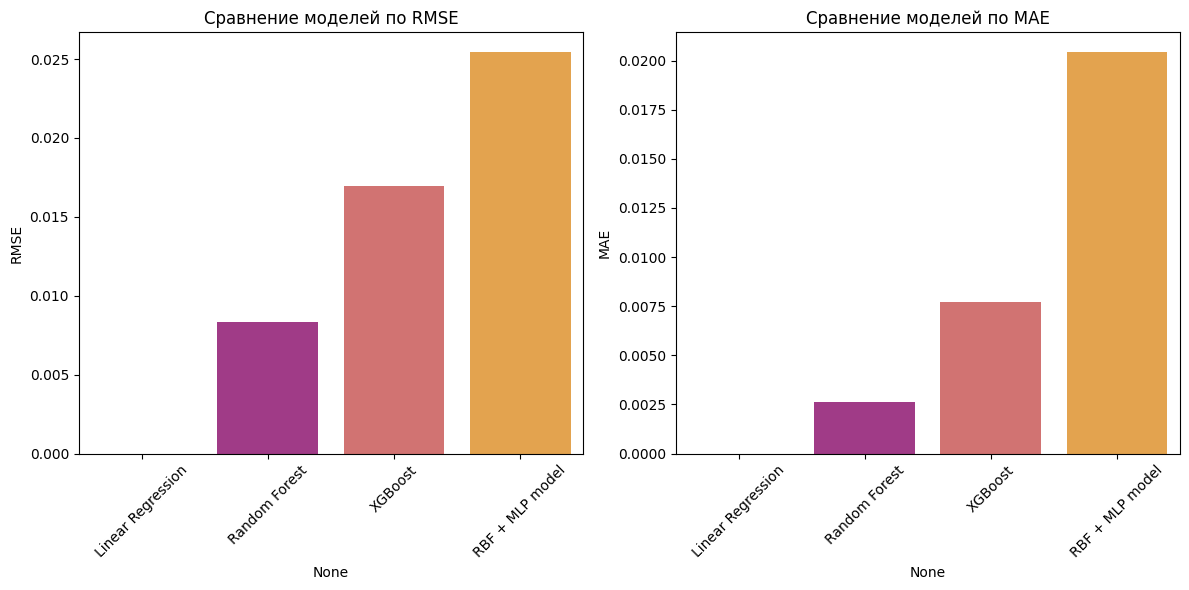

In [72]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=results.index, y=results["rmse"], palette="plasma")
plt.title("Сравнение моделей по RMSE")
plt.xticks(rotation=45)
plt.ylabel("RMSE")

plt.subplot(1, 2, 2)
sns.barplot(x=results.index, y=results["mae"], palette="plasma")
plt.title("Сравнение моделей по MAE")
plt.xticks(rotation=45)
plt.ylabel("MAE")

plt.tight_layout()
plt.show()

Целевая переменная имеет выраженную линейную зависимость

Из-за линейности задачи RBF не эффективна

# 6. Анализ результатов

1. Реализован и протестирован класс RBF слой нейронной сети
2. Написан ряд методов оптимизации RBF слоя
3. Исследован вопрос проявления в данной задачи проклятия размерности
4. Обучен ряд моделей для оценки рейтинга команды
5. Проведено сравнение различных моделей для решения задачи

![methods_diff.png|200](imgs/methods_diff.png)

![models_diff](imgs/models_diff.png)

RBF архитектура не подходит для решения данной задачи, так как зависимость целевой переменной с признаками - линейная. 
Поэтому другие более простые модели будут давать сопоставимый(а иногда и более сильный) результат за меньшее время

In [73]:
def create_model(num_centers=52):
    inputs = Input(shape=(x_train.shape[1],))
    rbf_layer = RBFLayer(num_centers)(inputs)
    x = Dense(1)(rbf_layer)
    model = tf.keras.Model(inputs, x)
    return model


model = create_model()
model.compile(optimizer="adam", loss="mse")
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=0)

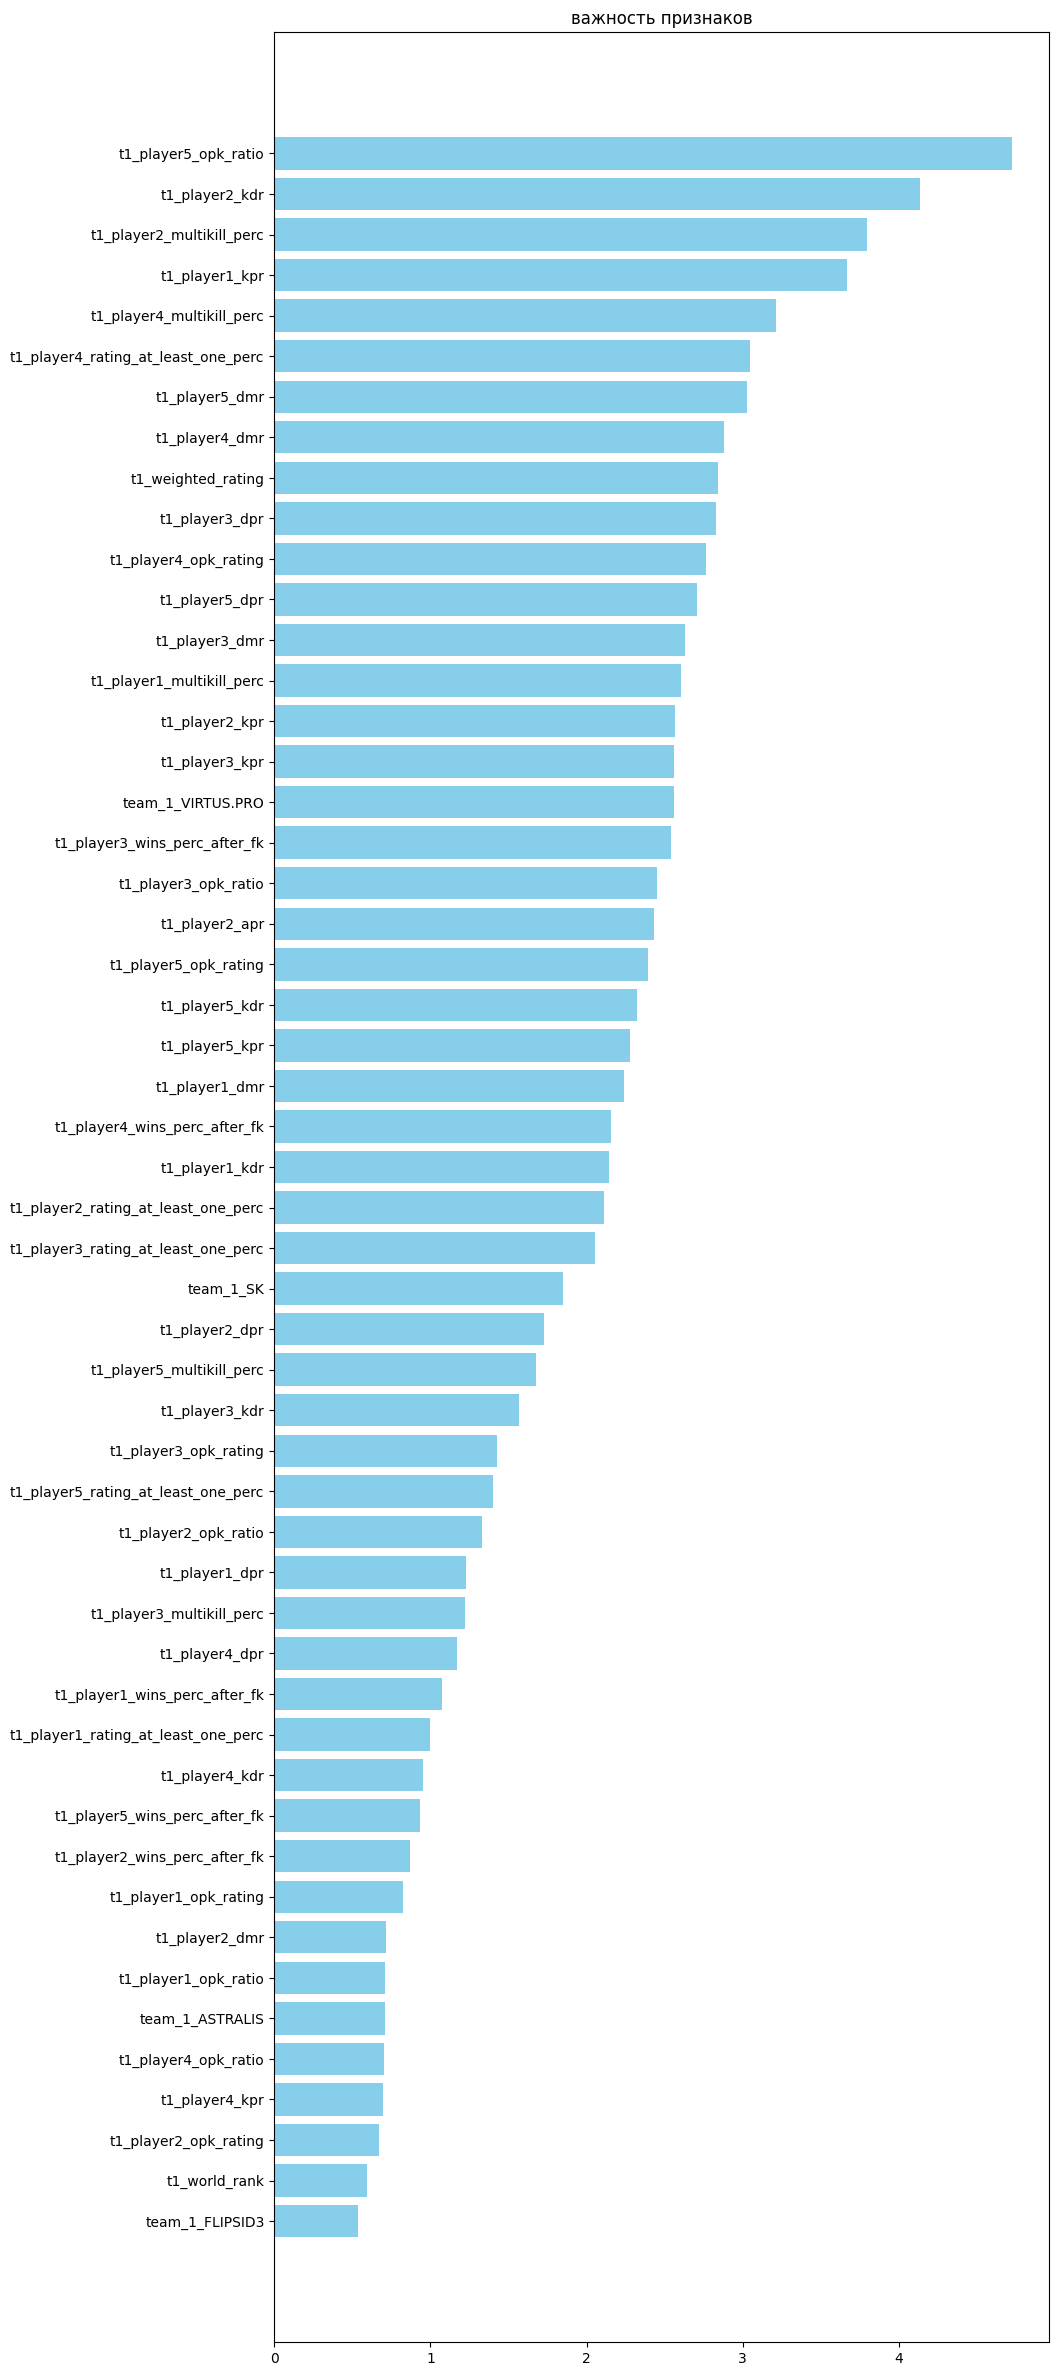

In [75]:
weights = model.layers[1].get_weights()[0]

importance_df = pd.DataFrame({"фича": features, "важность": np.abs(weights.flatten())})
importance_df = importance_df.sort_values(by="важность", ascending=False)

plt.figure(figsize=(10, 30))
plt.title("важность признаков")
plt.barh(importance_df["фича"], importance_df["важность"], color="skyblue")
plt.gca().invert_yaxis()
plt.show()

**Перспективы**
1. Обработать выбросы.
2. Расширить датасет добавив строки из датасета, где `t1` и `t2` метрики поменяны местами.
3. Перевести всё на рельсы `pythorch`.
    - Более сложная либа, но работает гораздо быстрее.

**Применимость датасета**
- Датасет больше подходит для статистического анализа, нежели для ML.
- Сама поставленная задача не слишком предназначена для решения алгоритмами ML, так как для вычисления рейтинга есть четкая формула.